## The 2-agent multi-agent Active Blockference

In [43]:
import itertools
import numpy as np
import seaborn as sns
from pymdp import utils
from copy import deepcopy
import matplotlib.pyplot as plt
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

sys.path.insert(0, '../../')

Now we define a helper plotting function

### Visualization functions

In [117]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[x, y] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def agent_plot(agent_locs):
    grid_dims = [3, 3]

    num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

    # create a look-up table `loc_list` that maps linear indices to tuples of (y, x) coordinates 
    grid = np.arange(num_grid_points).reshape(grid_dims)
    it = np.nditer(grid, flags=["multi_index"])

    loc_list = []
    while not it.finished:
        loc_list.append(it.multi_index)
        it.iternext()


    agent_loc_names = ['Agent1', 'Agent2']
    agent_locations = agent_locs

    fig, ax = plt.subplots(figsize=(10, 6)) 

    # create the grid visualization
    X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
    h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
    # ax.invert_yaxis()

    text_offsets = [0.4, 0.6]

    cue_grid = np.ones(grid_dims)
    for ii, loc_ii in enumerate(agent_locations):
      row_coord, column_coord = loc_ii
      cue_grid[row_coord, column_coord] = 5.0
      ax.text(column_coord+text_offsets[0], row_coord+text_offsets[1], agent_loc_names[ii], fontsize = 15, color='k')
    h.set_array(cue_grid.ravel())

Next we define the gridworld the agents will occupy

Position dictionary is {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}
Grid locations are [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]


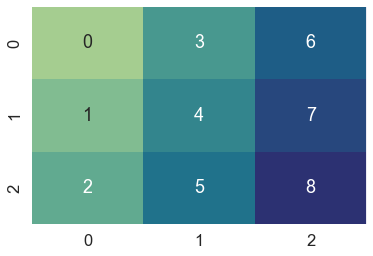

In [104]:
grid_locations = list(itertools.product(range(3), repeat=2))
num_grid_points = len(grid_locations)

pos_dict = {}
for i in range(0, len(grid_locations)):
    pos_dict[i] = grid_locations[i]
plot_grid(grid_locations)
print(f'Position dictionary is {pos_dict}')
print(f'Grid locations are {grid_locations}')

## Construct the A matrix

The A matrix represents the likelihood mapping between agents' observations and their hidden states.

In the 2 agent case, a single agents observes:
1. its current location (1 out of 9 for a 3x3 grid world)
2. the location of the other agent (1 out of 9 for a 3x3 grid world)

This means the A matrix needs to be a rank 2 tensor with each submatrix representing beliefs over a location, given an observation of my location and the observation of the other agent's location.

The number of possible locations for both agents is the same (9).

**The resulting shape of the A matrix should be (2,) with each submatrix being (9, 9, 9).**

#### States and observations in the 3x3 grid world for 2 agents

The first agent has 9 possible locations to visit in the grid world. The second agent does as well.

We will encode the number of states in a sparse representation, by modality. The first modality is the location of the agent receiving the observation, the second is the location of the other agent.

In [46]:
num_states = [len(grid_locations), len(grid_locations)]; num_states

[9, 9]

In [47]:
num_factors = len(num_states); num_factors

2

The number of observations is the same as the number of states (hidden states).

In [48]:
num_obs = [len(grid_locations), len(grid_locations)]

The shape of the A matrix is determined by the dimension of each respective modality and the number thereof.

To recap, the number of modalities is 2: The first modality is the location of the agent receiving the observation, the second is the location of the other agent.

The dimension of each modality is 9x9 (same as the grid world).

Hence, we can define the shape of the A matrix as [[9, 9], [9, 9]].

In [49]:
A_m_shapes = [[9, 9, 9], [9, 9, 9]]; A_m_shapes

[[9, 9, 9], [9, 9, 9]]

From the general shape, we construct the A matrix with the help of pymdp's `obj_array_zeros` function, which will just initialize the matrix with null entries (we'll fill in the correct entries later).

In [50]:
A = utils.obj_array_zeros(A_m_shapes); A

array([array([[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0.

For instance, `A[0][3,1,4]` encodes the likelihood of seeing myself in location 3, given that I am in location 1 and my neighbour is in location 4.

For the fully observable case, the indexes `A[0][n, n, m]` where n != m is 1, all other indexes are 0.
Equivalently, we have `A[1][n, m, n] = 1` for n != m.

In [51]:
# # for A[0]
# for i in range(0, 9):
#     for j in range(0, 9):
#         if i != j:
#             A[0][i, i, j] = 1 / 8

# # for A[1]
# for i in range(0, 9):
#     for j in range(0, 9):
#         if i != j:
#             A[1][i, j, i] = 1.0

# To avoid pymdp normalization error, NOTE: This does not encode the fact that the agents cannot collide.
# for A[0]
for i in range(0, 9):
    for j in range(0, 9):
        A[0][i, i, j] = 1.0

# for A[1]
for i in range(0, 9):
    for j in range(0, 9):
        A[1][i, j, i] = 1.0

In [52]:
A

array([array([[[1., 1., 1., 1., 1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [1., 1., 1., 1., 1., 1., 1., 1., 1.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0., 0., 0.

## Construct the B matrix

The B matrix should look exactly the same as in the single-agent case, because the position of the other agent, while an observation encoded in the A matrix, is not a controllable modality, hence there is no representation of its transition dynamics in the B matrix.

In [53]:
B_m_shapes = [[9, 9, 5], [9, 9, 1]]; B_m_shapes

[[9, 9, 5], [9, 9, 1]]

In [54]:
B = utils.obj_array_zeros(B_m_shapes); B

array([array([[[0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.

In [55]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[0][next_state, curr_state, action_id] = 1.0

In [56]:
for i in range(0, 9):
    B[1][i, i] = 1.0
print(B[1].sum(axis=0))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [57]:
B.shape

(2,)

In [58]:
B

array([array([[[1., 0., 1., 0., 1.],
               [0., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 1., 0.],
               [1., 0., 0., 0., 1.],
               [0., 0., 1., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.]],

              [[0., 0., 0., 0., 0.],
               [0., 0., 0., 1., 0.],
               [1., 0., 0., 1., 1.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [1., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.],
               [0., 0., 0., 0., 0.

## Construct the C matrix

C encodes the preferred state of the agent, i.e. the location the agent is trying to reach.

This is where we need to consider the two C matrices for the individual agents, since they're going to differ from each other depending on the preferred location they're trying to reach.

In this case of a 3x3 grid world, let's say the first agent wants to reach location (2, 2), i.e. location 8 (Note: the starting index is 0), and the second agent wants to reach location (1, 0), i.e. location 3 in the above visualization.

We encode the C matrix as a one-hot vector, where 1 is placed at the index of the preferred location (0s otherwise).

Note: we also define a helper function for creating a flat distribution denoting no preference over the second observation modality (i.e. the state of the *other* agent). Later, we're going to use the pymdp `Agent` class which requires the shape of C to match the number of observation modalities.

In [59]:
def create_flat_dist(num_values):
    arr = np.zeros(num_values)
    for i, _ in enumerate(arr):
        arr[i] = 1.0 / num_values
    return arr

We define the shape of the C matrix in the same way we did the A matrix.

In [60]:
C_m_shapes = [[9], [9]]

In [61]:
C = utils.obj_array_zeros(C_m_shapes); C

array([array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
       array([0., 0., 0., 0., 0., 0., 0., 0., 0.])], dtype=object)

In [62]:
agent1_C = deepcopy(C)

In [63]:
agent1_C[0] = utils.onehot(8, num_grid_points); agent1_C[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [64]:
agent1_C[1] = create_flat_dist(num_grid_points); agent1_C[1]

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [65]:
print(f'Agent 1 C matrix: {agent1_C}')

Agent 1 C matrix: [array([0., 0., 0., 0., 0., 0., 0., 0., 1.])
 array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111])           ]


Now we define the second agent's C matrix in an equivalent way.

In [66]:
agent2_C = deepcopy(C)
agent2_C[0] = utils.onehot(3, num_grid_points)
agent2_C[1] = create_flat_dist(num_grid_points)

print(f'Agent 2 C matrix: {agent2_C}')

Agent 2 C matrix: [array([0., 0., 0., 1., 0., 0., 0., 0., 0.])
 array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111])           ]


## Construct the D matrix

The D matrix encodes the prior belief about where the state of the grid world, including the position of the first agent and the second agent. Much like the C matrix, we need to create 2 such objects for each of the agents.

Let's say the first agent starts in location (0, 0), index 0, and the second in location (2, 1), index 7.

In [67]:
agent1_D = utils.obj_array(2)

agent1_D[0] = utils.onehot(0, 9)
agent1_D[1] = utils.onehot(7, 9)
print(f'Agent 1 D matrix: {agent1_D}')

agent2_D = utils.obj_array(2)

agent2_D[0] = utils.onehot(7, 9)
agent2_D[1] = utils.onehot(0, 9)
print(f'Agent 2 D matrix: {agent2_D}')

Agent 1 D matrix: [array([1., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0., 0., 0., 0., 0., 0., 0., 1., 0.])]
Agent 2 D matrix: [array([0., 0., 0., 0., 0., 0., 0., 1., 0.])
 array([1., 0., 0., 0., 0., 0., 0., 0., 0.])]


## Construct the E matrix (optional)

We've already defined the E matrix when we were initializing the B matrix, it only consists of the actions available to the agents.

The E vector is in terms of policies, not actions, so its size will depend on the length of planning we want the agent to undertake.

**Note**: We don't need to create the E matrix ourselves unless we want to specify the prior on specific policies, the `Agent` class in pymdp will initialize the E matrix for us (with a uniform distribution, i.e. each policy is equally likely).

In [68]:
from pymdp.control import construct_policies

In [69]:
policies_1 = construct_policies(num_states, num_controls=[5, 1], policy_len=1)
print(f'Length of policies_1 is {len(policies_1)}')
policies_2 = construct_policies(num_states, num_controls=[5, 1], policy_len=2)
print(f'Length of policies_2 is {len(policies_2)}')
policies_3 = construct_policies(num_states, num_controls=[5, 1], policy_len=3)
print(f'Length of policies_3 is {len(policies_3)}')
policies_4 = construct_policies(num_states, num_controls=[5, 1], policy_len=4)
print(f'Length of policies_4 is {len(policies_4)}')

Length of policies_1 is 5
Length of policies_2 is 25
Length of policies_3 is 125
Length of policies_4 is 625


## Construct the two Agents

Now that we've defined all the components for our two agents, initializing them is taken care of by the pymdp `Agent` class.

In [70]:
from pymdp.agent import Agent

In [71]:
agent1 = Agent(A=deepcopy(A), B=deepcopy(B), C=agent1_C, D=agent1_D, policy_len=4)
agent2 = Agent(A=deepcopy(A), B=deepcopy(B), C=agent2_C, D=agent2_D, policy_len=4)

## Initialize the initial observation of the agents

In this case, we'll have the environment generate the same observation as the agent's prior beliefs (encoded in the D vector).

This means `agent1` will receive the observation that it is in location 0 and the other agent is in location 7, whereas `agent2` will receive the observation that it is in location 7 and the other agent (`agent1`) is in location 0.

In [72]:
agent1_init_obs = deepcopy(agent1.D)
agent2_init_obs = deepcopy(agent2.D)

# here we just change the elements of the subarrays to integers instead of floats (it's a pymdp requirement)
for i in range(2):
    agent1_init_obs[i] = agent1_init_obs[i].astype(int)
    agent2_init_obs[i] = agent2_init_obs[i].astype(int)

print(f"Agent1 observation: {agent1_init_obs}")
print(f"Agent2 observation: {agent2_init_obs}")

Agent1 observation: [array([1, 0, 0, 0, 0, 0, 0, 0, 0]) array([0, 0, 0, 0, 0, 0, 0, 1, 0])]
Agent2 observation: [array([0, 0, 0, 0, 0, 0, 0, 1, 0]) array([1, 0, 0, 0, 0, 0, 0, 0, 0])]


## Prepare the environment instance

For this we import the `TwoMultiGridAgent` class from `blockference.envs`.

In [73]:
agent2_init_obs

array([array([0, 0, 0, 0, 0, 0, 0, 1, 0]),
       array([1, 0, 0, 0, 0, 0, 0, 0, 0])], dtype=object)

In [77]:
from blockference.envs.grid_env_multi import TwoMultiGridAgent

env = TwoMultiGridAgent(grid_len=3, grid_dim=2, agents=[agent1, agent2], init_pos=[0, 7], init_obs=[agent1_init_obs, agent2_init_obs])
# env = TwoMultiGridAgent(grid_len=3, grid_dim=2, agents=[agent2, agent1], init_pos=[7, 0], init_obs=[agent2_init_obs, agent1_init_obs])

Position dictionary is {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}
Agents are occupying the states [(2, 1), (0, 0)]
Initial observation vectors of the agents: [array([array([1, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 1, 0])], dtype=object), array([array([0, 0, 0, 0, 0, 0, 0, 1, 0]),
       array([1, 0, 0, 0, 0, 0, 0, 0, 0])], dtype=object)]


## Debugging TwoMultiGridAgent

In [133]:
from pymdp import utils
import copy
import sys

sys.path.insert(0, '../../')
from blockference.gridference import *


LOCATION_FACTOR_ID = 0
OTHER_AGENT_FACTOR_ID = 1

class TwoMultiGridAgent():
    def __init__(self, grid_len, grid_dim=2, agents=[], init_pos=[], init_obs=[]) -> None:
        """
        The GridAgent class represent the gridworld environment and keeps track of the locations of the individual agents.
        
        Params:
            grid_len: length of the gridworld
            grid_dim: dimension of the gridworld
            agents: list of agents in the environment
            init_pos: list of initial positions of the agents
            init_obs: list of initial observations the agents receive
        """
        self.grid = self.get_grid(grid_len, grid_dim)
        
        self.border = np.sqrt(len(self.grid)) - 1
        
        self.pos_dict = {}
        for i in range(0, len(self.grid)):
            self.pos_dict[i] = self.grid[i]
        print(f'Position dictionary is {self.pos_dict}')

        self.num_states = grid_len ** 2

        self.current_state = init_pos # make them indexes
        print(f'Agents are occupying the states {[self.pos_dict[v] for v in init_pos]}')
        
        self.current_obs = init_obs
        print(f'Initial observation vectors of the agents: {init_obs}')

        self.affordances = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

        assert len(self.current_state) == len(agents), "Number of occupied states is not equal to the number of agents"
        self.agent_plot([self.pos_dict[self.current_state[0]], self.pos_dict[self.current_state[1]]])

    def step(self, actions):
        """
        Step function for the gridworld environment.

        Params:
            actions: list of actions chosen by the agents in the environment
        """
        new_states = []
        agent_locs = []

        for idx, action in enumerate(actions):
            # get indexes of the current reference agent and the other agent (2-agent case, in the future might be handled with a dict)
            agent_idx = idx
            other_agent_idx = 0 if agent_idx == 1 else 1
            
            # get state of other agent
            other_agent_state = self.current_state[other_agent_idx]
            
            # get word action label
            action_label = self.affordances[int(action[0])]

            x, y = self.pos_dict[self.current_state[agent_idx]]
            

            if action_label == "DOWN":
                next_y = y + 1 if y < self.border else y
                next_x = x
            elif action_label == "UP":
                next_y = y - 1 if y > 0 else y
                next_x = x
            elif action_label == "LEFT":
                next_x = x - 1 if x > 0 else x
                next_y = y
            elif action_label == "RIGHT":
                next_x = x + 1 if x < self.border else x
                next_y = y
            elif action_label == "STAY":
                next_x = x
                next_y = y
            else:
                raise ValueError(f'Action {action_label} not recognized')

            new_location = (next_x, next_y)
            new_agent_state = list(self.pos_dict.keys())[list(self.pos_dict.values()).index(new_location)] # returns index!
            # check for collisions
            if new_agent_state == other_agent_state:
                print("Almost collided!")
                new_agent_state = self.current_state[agent_idx] # i.e. could not perform the action
                new_location = (x, y)
            print(f"New location for agent {agent_idx} is {new_location}")
                
            agent_locs.append(new_location)
            new_states.append(new_agent_state)

        self.current_state = new_states
        self.agent_plot(agent_locs)
        # Now generate new observations for each agent (after they have both taken a step)
        new_current_obs = []
        
        for i in range(2): # not general, just for the two agents
            agent_idx = i
            other_agent_idx = 0 if agent_idx == 1 else 1
            new_current_obs.append([utils.onehot(new_states[agent_idx], self.num_states).astype(int), utils.onehot(new_states[other_agent_idx], self.num_states).astype(int)])
        
        self.current_obs = new_current_obs
            

        return self.current_obs # update both agents at the same time, need to be optimized in future iterations

    def get_grid(self, grid_len, grid_dim):
        g = list(itertools.product(range(grid_len), repeat=grid_dim))
        return g
    
    def agent_plot(self, agent_locs):
        grid_dims = [3, 3]

        num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

        # create a look-up table `loc_list` that maps linear indices to tuples of (y, x) coordinates 
        grid = np.arange(num_grid_points).reshape(grid_dims)
        it = np.nditer(grid, flags=["multi_index"])

        loc_list = []
        while not it.finished:
            loc_list.append(it.multi_index)
            it.iternext()


        agent_loc_names = ['Agent1', 'Agent2']
        agent_locations = agent_locs

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_ylabel("y")
        ax.set_xlabel("x")

        # create the grid visualization
        X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
        h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')

        text_offsets = [0.4, 0.6]

        cue_grid = np.ones(grid_dims)
        for ii, loc_ii in enumerate(agent_locations):
          row_coord, column_coord = loc_ii
          cue_grid[row_coord, column_coord] = 5.0
          ax.text(column_coord+text_offsets[0], row_coord+text_offsets[1], agent_loc_names[ii], fontsize = 15, color='k')
        h.set_array(cue_grid.ravel())

Position dictionary is {0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 8: (2, 2)}
Agents are occupying the states [(0, 0), (2, 1)]
Initial observation vectors of the agents: [array([array([1, 0, 0, 0, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0, 1, 0])], dtype=object), array([array([0, 0, 0, 0, 0, 0, 0, 1, 0]),
       array([1, 0, 0, 0, 0, 0, 0, 0, 0])], dtype=object)]


/var/folders/vc/5b_s57r96czcz93nfrdkmhwc0000gn/T/ipykernel_89734/3768641486.py:143: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')


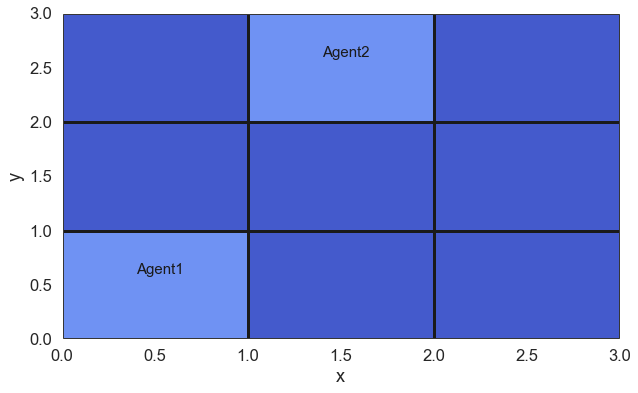

In [134]:
env = TwoMultiGridAgent(grid_len=3, grid_dim=2, agents=[agent1, agent2], init_pos=[0, 7], init_obs=[agent1_init_obs, agent2_init_obs])

/var/folders/vc/5b_s57r96czcz93nfrdkmhwc0000gn/T/ipykernel_89734/2376439468.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')


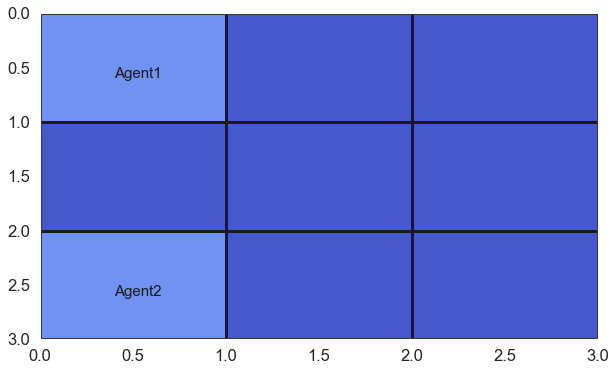

In [105]:
agent_plot([(0, 0), (2, 0)])

## Sanity check #1: Single-timestep active inference loop

In [109]:
affordances = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]; affordances

['UP', 'DOWN', 'LEFT', 'RIGHT', 'STAY']

In [ ]:
observations = [agent1_init_obs, agent2_init_obs]
actions = []
word_actions = []

for idx, agent in enumerate([agent1, agent2]):
    obs = observations[idx]
    print(f"Obs: {obs}")
    qx = agent.infer_states(obs)

    q_pi, efe = agent.infer_policies()

    action = agent.sample_action()
    print(action)
    word_actions.append(affordances[int(action[0])])
    actions.append(action)

Obs: [array([1, 0, 0, 0, 0, 0, 0, 0, 0]) array([0, 0, 0, 0, 0, 0, 0, 1, 0])]
[3. 0.]
Obs: [array([0, 0, 0, 0, 0, 0, 0, 1, 0]) array([1, 0, 0, 0, 0, 0, 0, 0, 0])]
[1. 0.]


In [121]:
word_actions

['RIGHT', 'DOWN']

## Sanity check #2: Updating the state in the environment

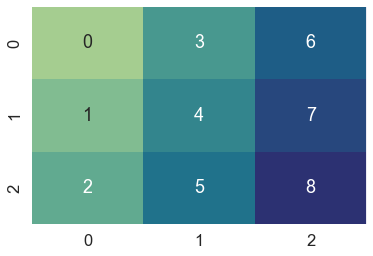

In [35]:
plot_grid(grid_locations)

New location for agent 0 is (1, 0)
New location for agent 1 is (2, 2)


/var/folders/vc/5b_s57r96czcz93nfrdkmhwc0000gn/T/ipykernel_89734/2120734228.py:141: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  h = ax.pcolormesh(Y, X, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')


[[array([0, 0, 0, 1, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1])],
 [array([0, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 0, 0, 1, 0, 0, 0, 0, 0])]]

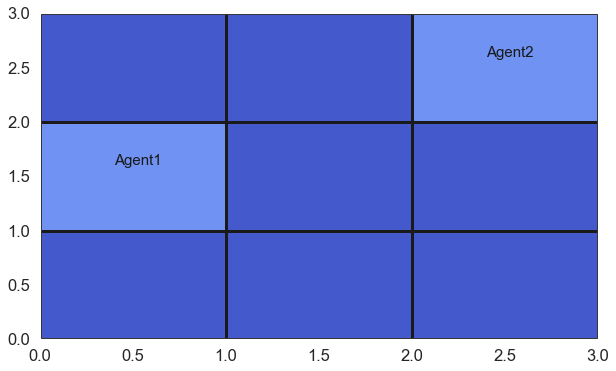

In [122]:
new_obs = env.step(actions); new_obs

In [37]:
print(new_obs[0])
print(new_obs[1])

[array([0, 0, 0, 0, 0, 0, 0, 0, 1]), array([0, 1, 0, 0, 0, 0, 0, 0, 0])]
[array([0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 1])]


## Sanity check #3: Full simulation (without cadCAD)

In [34]:
agent2.C = deepcopy(C)
agent2.C[1] = create_flat_dist(num_grid_points)
agent2.C[0] = utils.onehot(0, num_grid_points)
print(agent2.C)

[array([1., 0., 0., 0., 0., 0., 0., 0., 0.])
 array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
        0.11111111, 0.11111111, 0.11111111, 0.11111111])           ]


['STAY', 'DOWN']
New location for agent 0 is (0, 0)
New location for agent 1 is (2, 2)


/var/folders/vc/5b_s57r96czcz93nfrdkmhwc0000gn/T/ipykernel_89734/170146544.py:141: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')


['DOWN', 'DOWN']
New location for agent 0 is (0, 1)
New location for agent 1 is (2, 2)
['DOWN', 'RIGHT']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['STAY', 'DOWN']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['DOWN', 'DOWN']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['DOWN', 'RIGHT']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['STAY', 'DOWN']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['DOWN', 'DOWN']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['DOWN', 'RIGHT']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)
['STAY', 'DOWN']
New location for agent 0 is (0, 2)
New location for agent 1 is (2, 2)


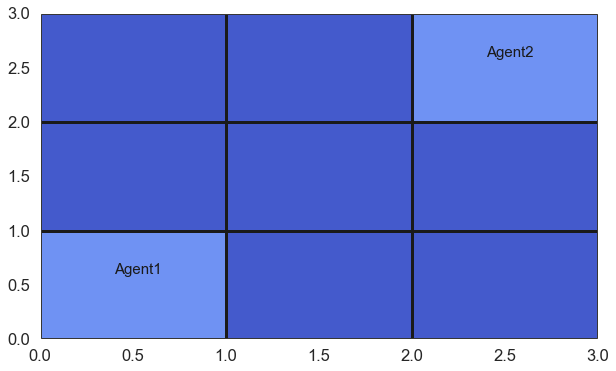

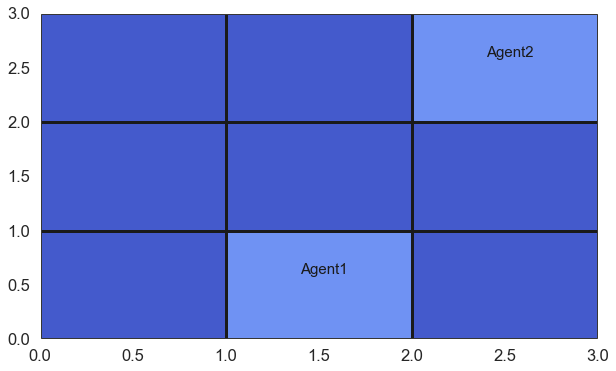

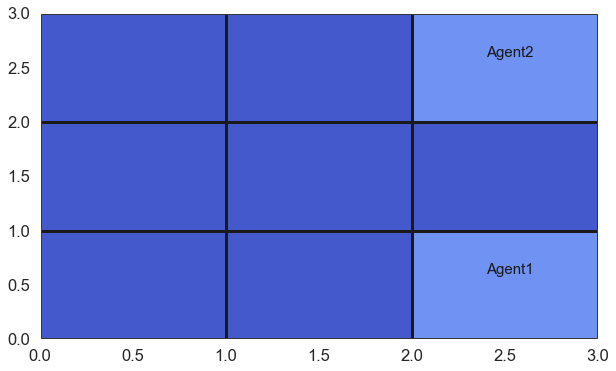

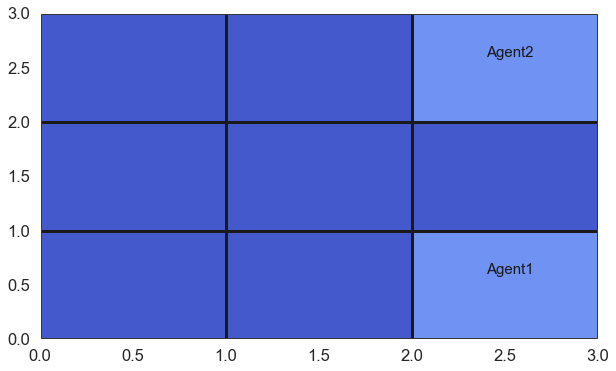

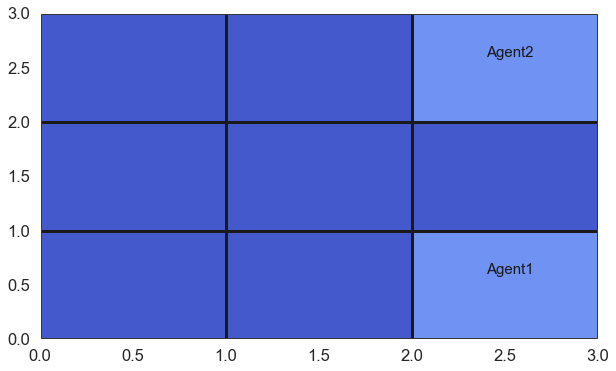

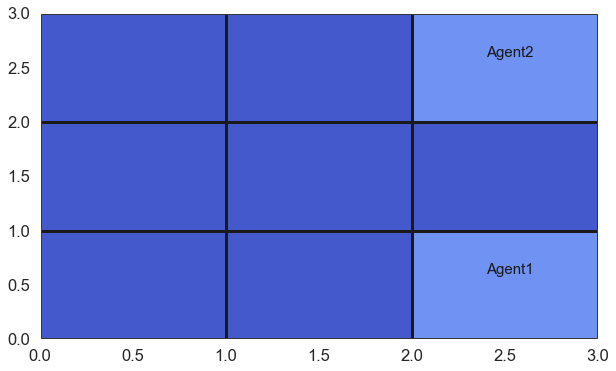

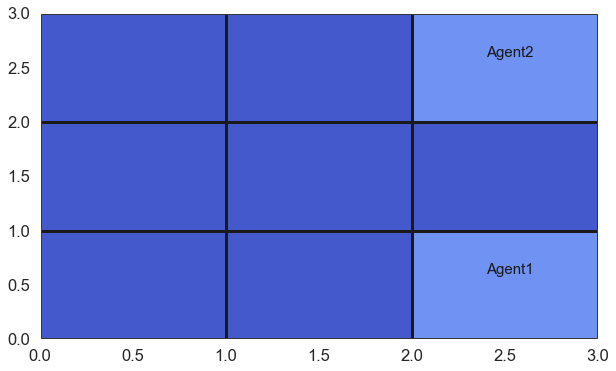

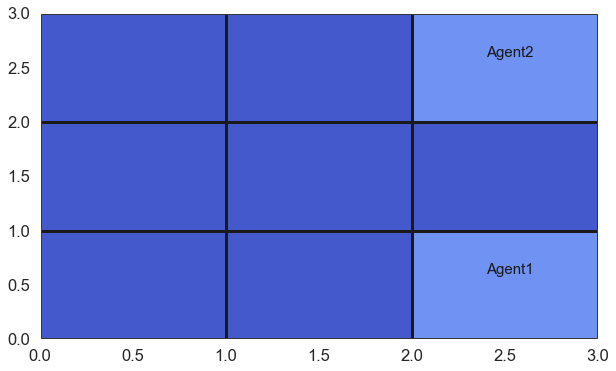

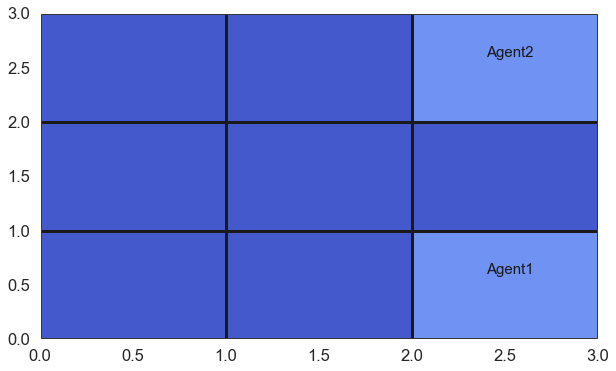

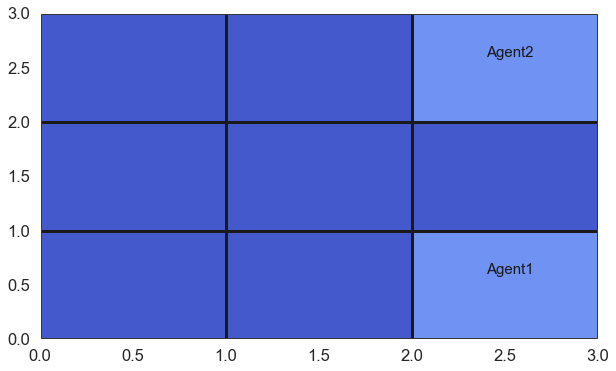

In [118]:
# observations = [agent1_init_obs, agent2_init_obs]
observations = [agent2_init_obs, agent1_init_obs]

actions = []
word_actions = []

for _ in range(10):
    actions = []
    word_actions = []
    # for idx, agent in enumerate([agent1, agent2]):
    for idx, agent in enumerate([agent2, agent1]):
        obs = observations[idx]
        # print(f"Obs: {obs}")
        qx = agent.infer_states(obs)

        q_pi, efe = agent.infer_policies()

        action = agent.sample_action()

        word_actions.append(affordances[int(action[0])])
        actions.append(action)
    print(word_actions)
    observations = env.step(actions)
    # print(f"New observations are: {observations}")

## Prepare cadCAD simulation

### Initializing the cadCAD simulation components

We need to specify the initial state, the simulation parameters (we won't need those now), the policy functions (not to be confused with active inference policies), and the state update functions.

In [52]:
initial_state = {
    'agent1': agent1,
    'agent2': agent2,
    'env': env,
    'obs': [agent1_init_obs, agent2_init_obs],
    'locations': env.current_state,
    'actions': [None, None]
}

In [53]:
params = {
}

Policy functions

In [54]:
def p_actinf(params, substep, state_history, previous_state):
    actions = []
    word_actions = []
    for idx, agent in enumerate([previous_state['agent1'], previous_state['agent2']]):

        obs = previous_state['obs'][idx]
        print(f"Obs: {obs}")
        qx = agent.infer_states(obs) 
        q_pi, efe = agent.infer_policies()

        action = agent.sample_action()
        word_actions.append(affordances[int(action[0])])
        actions.append(action)

    return {'update_actions': actions,
            'update_word_actions': word_actions}

State-update functions

In [55]:
def s_obs(params, substep, state_history, previous_state, policy_input):
    updated_obs = previous_state['env'].step(policy_input['update_actions'])
    return 'obs', updated_obs

def s_act(params, substep, state_history, previous_state, policy_input):
    return 'actions', policy_input['update_word_actions']

### Putting it all together

Now we connect out policies and state-update functions in the so called "state update blocks". This allows us to compose different components of the simulation either in series or in parallel. In future work, we can explore how we can decompose the generative model and the message passing schemes within the state update blocks. There's also interesting work to be done in composing general multi-agent simulations (Do agents take actions in series or in parallel? How does that change the behavior of the system?).

In [60]:
state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'obs': s_obs,
            'actions': s_act,
        }
    }
]

In [61]:
from radcad import Model, Simulation

model = Model(
    # Model initial state
    initial_state=initial_state,
    # Model Partial State Update Blocks
    state_update_blocks=state_update_blocks,
    # System Parameters
    params=params
)

simulation = Simulation(
    model=model,
    timesteps=20,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)

In [62]:
result = simulation.run()

Obs: [array([1, 0, 0, 0, 0, 0, 0, 0, 0]) array([0, 0, 0, 0, 0, 0, 0, 1, 0])]
Obs: [array([0, 0, 0, 0, 0, 0, 0, 1, 0]) array([1, 0, 0, 0, 0, 0, 0, 0, 0])]
self.border is 2.0
taking action DOWN
x, y = (0, 0)
next_x, next_y = (0, 1)
self.border is 2.0
New agent states are [1, 7]
New observations are [[array([0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1, 0])], [array([0, 0, 0, 0, 0, 0, 0, 1, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0])]]
Obs: [array([0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1, 0])]
Obs: [array([0, 0, 0, 0, 0, 0, 0, 1, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0])]
self.border is 2.0
taking action DOWN
x, y = (0, 0)
next_x, next_y = (0, 1)
self.border is 2.0
New agent states are [1, 7]
New observations are [[array([0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1, 0])], [array([0, 0, 0, 0, 0, 0, 0, 1, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0])]]
Obs: [array([0, 1, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 1, 0])]
Obs: [array([0, 0, 0, 0, 0

In [63]:
result

[{'agent1': <pymdp.agent.Agent at 0x172f377f0>,
  'agent2': <pymdp.agent.Agent at 0x17301b310>,
  'env': <blockference.envs.grid_env_multi.TwoMultiGridAgent at 0x17301b430>,
  'obs': [array([array([1, 0, 0, 0, 0, 0, 0, 0, 0]),
          array([0, 0, 0, 0, 0, 0, 0, 1, 0])], dtype=object),
   array([array([0, 0, 0, 0, 0, 0, 0, 1, 0]),
          array([1, 0, 0, 0, 0, 0, 0, 0, 0])], dtype=object)],
  'locations': [0, 7],
  'actions': [None, None],
  'simulation': 0,
  'subset': 0,
  'run': 1,
  'substep': 0,
  'timestep': 0},
 {'agent1': <pymdp.agent.Agent at 0x172f377f0>,
  'agent2': <pymdp.agent.Agent at 0x17301b310>,
  'env': <blockference.envs.grid_env_multi.TwoMultiGridAgent at 0x17301b430>,
  'obs': [[array([0, 1, 0, 0, 0, 0, 0, 0, 0]),
    array([0, 0, 0, 0, 0, 0, 0, 1, 0])],
   [array([0, 0, 0, 0, 0, 0, 0, 1, 0]), array([0, 1, 0, 0, 0, 0, 0, 0, 0])]],
  'locations': [0, 7],
  'actions': ['DOWN', 'STAY'],
  'simulation': 0,
  'subset': 0,
  'run': 1,
  'substep': 1,
  'timestep': 1}